<a href="https://colab.research.google.com/github/JonasZaoui/CarDetection/blob/main/CarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation des librairies et git

In [1]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 38.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=80a8c57e845264764a022256be1bb94547f1dab2d210f4323ae8b864e82c5129
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 74553, done.
remote: Counting objects: 100% (9615/9615), done.
remote: Compressing objects: 100% (798/798), done.
remote: Total 74553 (delta 8827), reused 9493 (delta 8764), pack-reused 64938
Receiving objects: 100% (74553/74553), 145.92 MiB | 31.45 MiB/s, done.
Resolving deltas: 100% (61950/61950), done.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
import os
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
from PIL import Image
import imageio
from xml.etree import ElementTree as et
import matplotlib.patches as patches #pour rectangle
import torchvision
from tqdm import tqdm
import utils
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as torchtrans  
from engine import train_one_epoch, evaluate
import pandas as pd

from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [5]:
path_train = '/content/drive/MyDrive/car-object-detection/data/training_images'
path_test = '/content/drive/MyDrive/car-object-detection/data/testing_images'

df_train= pd.read_csv('/content/drive/MyDrive/car-object-detection/data/train_solution_bounding_boxes (1).csv')
df_test = pd.read_csv('/content/drive/MyDrive/car-object-detection/data/sample_submission.csv')

In [ ]:
df_train.shape

(559, 5)

In [23]:
image_ids = df_train['image'].unique() #nom des images du dataframe = donc avec voiture sur l'image

test_ids = image_ids[-100:] #100 images sur le test set
train_ids = image_ids[:459] #459 images sur le train set


df_test = df_train[df_train['image'].isin(test_ids)] 
df_train = df_train[df_train['image'].isin(train_ids)]


In [24]:
class CarDetectionDataset(torch.utils.data.Dataset):

    def __init__(self,dataframe,image_dir,transforms=None):
        super().__init__()

        self.df = dataframe
        self.transforms = transforms
        self.image_dir = image_dir #path du train ou du test dossier
        #self.class_names = [_,'car'] #_ = background. 

        #PAS CA CAR ON AFFICHE MEME LES IMAGES SANS BOUNDING BOX  
        #self.imgs = [image for image in sorted(os.listdir(self.files_dir))
                        #if image[-4:]=='.jpg'] #liste des images du file_dir qu'on rentre
        
        self.image_ids = dataframe['image'].unique() #tous les noms d'images 


    def __getitem__(self, idx):   

        #img_name = self.imgs[idx]
        #img_path = os.path.join(self.files_dir,img_name)
        image_id = self.image_ids[idx]
        records = self.df[self.df["image"] == image_id]

        img_file = os.path.join(self.image_dir,image_id) #path de l'image choisie.

        # reading the images and converting them to correct size and color  
        image = cv2.imread(img_file, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        # diving by 255
        image /= 255.0
  
        #labels : il n'y a qu'une classe. de dimension le nombre de bounding box = nb d'objets. 
        # =1 car les images du dataframe contiennent un objet. 
        labels = torch.ones((records.shape[0]), dtype=torch.int64)
    
        # cv2 image gives size as height x width
        #wt = img.shape[1]
        #ht = img.shape[0]
            
        # convert boxes into a torch.Tensor
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
              
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
      
        #labels = 1 because 1 class
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])


        if self.transforms:
            
            sample = self.transforms(image = image,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            image = sample['image'] 
            target['boxes'] = torch.tensor(sample['bboxes']) #on convertit en tenseur
       

        return image, target, image_id

    def __len__(self):

        return self.image_ids.shape[0]


# check dataset
dataset = CarDetectionDataset(df_train,path_train)

# getting the image and target for a test index.  Feel free to change the index.
image, target,image_id = dataset[5]
print(image.shape, '\n',target)
print(len(dataset))



        
      

(380, 676, 3) 
 {'boxes': tensor([[447.5687, 160.6258, 582.0839, 232.5177]], dtype=torch.float64), 'labels': tensor([1]), 'area': tensor([9670.5518]), 'iscrowd': tensor([0]), 'image_id': tensor([5])}
355


- x = xmin
- y = ymin
- Alors w = xmax - xmin
- Et h = ymax - ymin

Ensuite on normalise 
x = xmin / width
y = ymin / height
w = (xmax - xmin) / width
h = (ymax - ymin) / height

In [ ]:
! pip install --upgrade opencv-python


     |████████████████████████████████| 60.4 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


### Visualisation des bounding box 

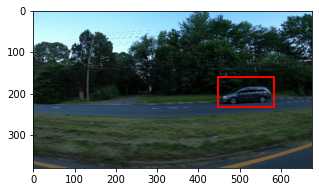

In [25]:
def plot_img_box(img,target):
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img) #on affiche l'image 
  for box in (target['boxes']): #on parcours les coordonnes de la box 
    x,y,width,height =  box[0], box[1], box[2]-box[0], box[3]-box[1] 
    rect = patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none') 


    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target, image_id = dataset[5]
plot_img_box(img, target)


In [63]:
#Chaque élément de la classe dataset contient une image,target, image_id.
# On affiche ici juste la target 
img, target, image_id = dataset[5]
target

{'area': tensor([9670.5518]),
 'boxes': tensor([[447.5687, 160.6258, 582.0839, 232.5177]], dtype=torch.float64),
 'image_id': tensor([5]),
 'iscrowd': tensor([0]),
 'labels': tensor([1])}

In [ ]:
# Pour mieux visualiser 
records = df_train[df_train["image"] == 'vid_4_9760.jpg']
records

,image,xmin,ymin,xmax,ymax
542,vid_4_9760.jpg,0.000000,197.829501,39.388201,230.316548
543,vid_4_9760.jpg,257.008012,178.140382,455.918427,242.130019
544,vid_4_9760.jpg,471.181355,177.648154,575.067735,222.933128


In [27]:
# format pascal voc = format [xmin,xmax,ymin,ymax]
def get_train_transform():
    return albumentations.Compose([
        albumentations.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

#def get_valid_transform():
    #return albumentations.Compose([
        #ToTensorV2(p=1.0)
    #], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [28]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [29]:
num_classes = 2 # 1 class (car) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
class Averager:
    def __init__(self):
        self.current_total = 0.0 #attribut
        self.iterations = 0.0 #attribut 

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property #value est une methode associée a property. 
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [57]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CarDetectionDataset(df_train, path_train, get_train_transform())
test_dataset = CarDetectionDataset(df_test, path_train, get_train_transform())  #JAI MIS LA TRANSFORME DU TRAIN SET 

# split the dataset in train and test set. retourne une liste. 
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

#valid_data_loader = DataLoader(
    #valid_dataset,
    #batch_size=4,
    #shuffle=False,
    #num_workers=4,
    #collate_fn=collate_fn
#)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
print(device) #cuda = gpu

cuda


In [32]:
images, targets,image_id = next(iter(train_data_loader))
images = list(image.to(device) for image in images) 
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)  #on recupere les coordonnes en numpy de la bounding box de l'image
sample = images[2].permute(1,2,0).cpu().numpy() #on choisit une image comme echantillon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


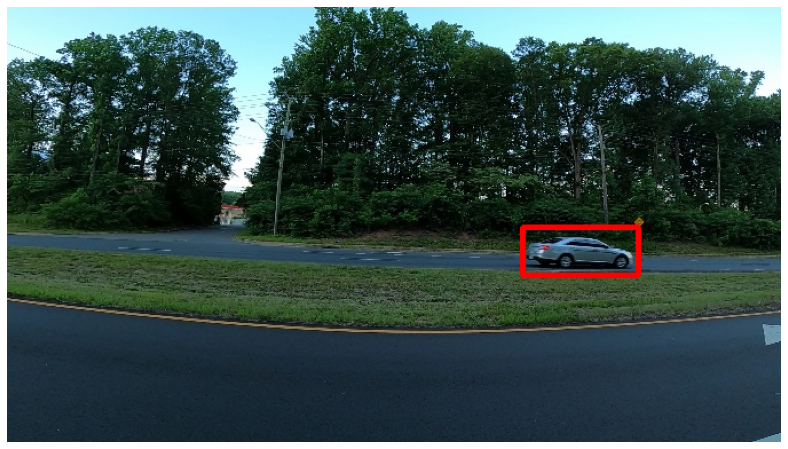

In [ ]:
#Encore une visualisation de données 

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

TRAIN 

In [33]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 4

In [ ]:
torch.cuda.empty_cache()

In [20]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  190697 KB |  190697 KB |  190697 KB |       0 B  |\n|       from large pool |  171008 KB |  171008 KB |  171008 KB |       0 B  |\n|       from small pool |   19689 KB |   19689 KB |   19689 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  190697 KB |  190697 KB |  190697 KB |       0 B  |\n|       from large pool |  171008 KB |  171008 KB |

In [34]:
from tqdm import tqdm

In [35]:
loss_hist = Averager()
itr = 1

for epoch in tqdm(range(num_epochs)):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 25%|██▌       | 1/4 [06:04<18:12, 364.32s/it]

Epoch #0 loss: 0.23978753386347287
Iteration #50 loss: 0.1812251462962322


 50%|█████     | 2/4 [12:08<12:08, 364.02s/it]

Epoch #1 loss: 0.13446266170751858
Iteration #100 loss: 0.05504121739116544


 75%|███████▌  | 3/4 [18:12<06:04, 364.04s/it]

Epoch #2 loss: 0.11925337301721127
Iteration #150 loss: 0.07303170319530167


100%|██████████| 4/4 [24:16<00:00, 364.05s/it]

Epoch #3 loss: 0.11308125775352171


In [36]:
torch.save(model.state_dict(), 'model_weights_cardetection.pth')


In [37]:
images, targets, image_ids = next(iter(test_data_loader))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [38]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [39]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy() #2eme image du test set 

In [40]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images) #prediction des images du ième batch du valid set 
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [41]:
outputs 

[{'boxes': tensor([[ 45.8552, 162.2634, 151.1109, 203.0437],
          [ 86.1888, 162.3484, 139.2541, 201.3288]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9896, 0.0620], grad_fn=<ToCopyBackward0>)},
 {'boxes': tensor([[260.4157, 131.2351, 445.7084, 196.8963],
          [306.6480, 133.5824, 394.2894, 194.5812]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9938, 0.0505], grad_fn=<ToCopyBackward0>)},
 {'boxes': tensor([[615.0510, 194.8627, 676.0001, 243.8082],
          [ 39.8213,  22.0851, 148.2295, 111.7681]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9879, 0.1780], grad_fn=<ToCopyBackward0>)},
 {'boxes': tensor([[  0.0000, 158.9383, 106.4363, 199.7598],
          [  1.4937, 162.4837,  61.9189, 198.2504]], grad_fn=<ToCopyBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9950, 0.0941], grad_fn=<ToCopyBackward0>)}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


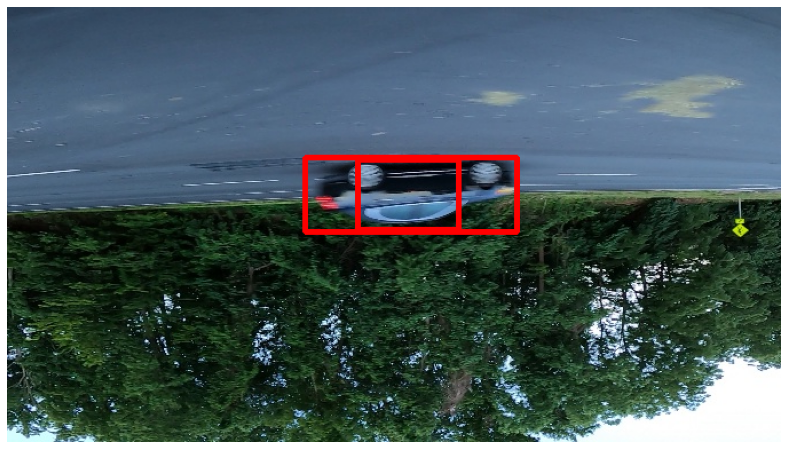

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in outputs[1]['boxes']:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [43]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
boxes

array([[617, 190, 676, 246]], dtype=int32)

In [44]:
sample2 = images[2].permute(1,2,0).cpu().numpy() #2eme image du valid set 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


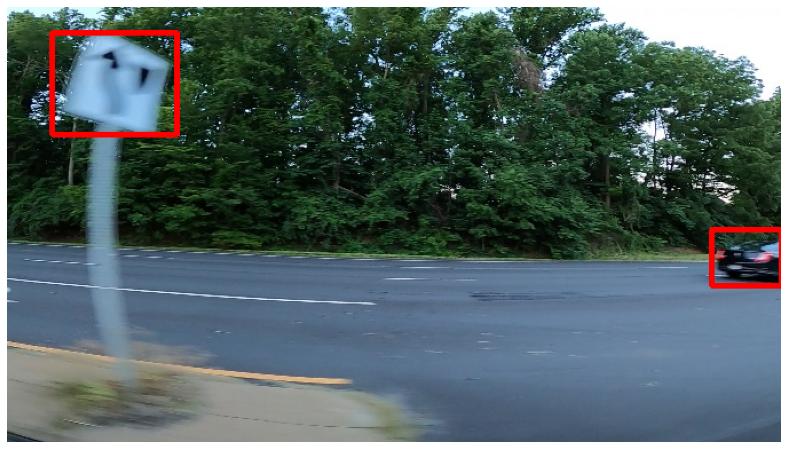

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in outputs[2]['boxes']:
    cv2.rectangle(sample2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample2)

In [46]:
def format_prediction_string(boxes, scores): ## Define the formate for storing prediction results
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [51]:
detection_threshold = 0.5

In [58]:
## Lets make the prediction
results=[]
model.eval()

for images, targets,image_ids in test_data_loader:    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]
        
        
            
        result = {                                     #Store the image id and boxes and scores in result dict.
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)              #Append the result dict to Results list

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [59]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,vid_4_3340.jpg,0.9896 527 161 103 40
1,vid_4_3440.jpg,0.9953 264 186 183 63
2,vid_4_3460.jpg,0.9879 615 194 61 49
3,vid_4_3520.jpg,0.9886 0 183 107 37
4,vid_4_3540.jpg,0.9928 234 143 115 43


In [61]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


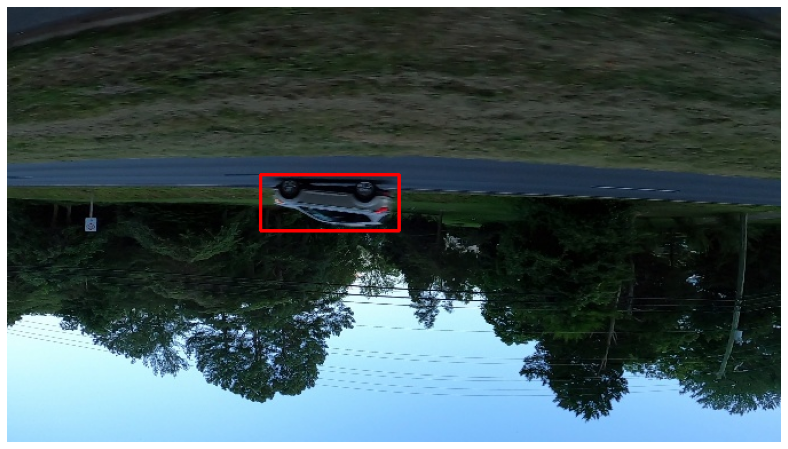

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)